# Load modules and data

In [7]:
import matplotlib
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from functools import partial
import glob
import sys
import logging
import multiprocessing
from p_tqdm import p_map
from itertools import compress
from os import path as ospath
import scipy.sparse

import os
os.environ['NUMEXPR_MAX_THREADS'] = '42'
os.environ['NUMEXPR_NUM_THREADS'] = '21'


logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

from helpers import track_tools


## Vectorize information about file location for better efficiency

In [16]:
species=list(map(lambda x: x.split("/")[1],glob.glob("Track_Data/*/")))
vectorized=list()
for spe in species:
    path = 'Track_Data/'+spe
    files = [f for f in glob.glob(path + "/**/all_tracks.csv", recursive=True)]
    for i in range(len(files)):
        vectorized.append([spe,i])

In [17]:
len(vectorized)

35

## functions that will load the data 

In [24]:
from helpers import line_intersection3
from itertools import groupby

numcores=21


#specie=["Echinopora"]

def gather_dat(vector):
    spe=vector[0]
    rep=vector[1]
    path = 'Track_Data/'+spe
    scale=pd.read_table('Track_Data/'+spe+'/scale',header=0)
    sc=scale["real_distance"][0]/scale["imaris_distance"][0]
    fl=next(os.walk(path))[1]
    fl=list(compress(fl, list(map(lambda x: x!=".ipynb_checkpoints",fl))))
    files = [f for f in glob.glob(path + "/**/all_tracks.csv", recursive=True)]
    adata=pd.concat(list(map(pd.read_csv,files)),keys=list(range(0,len(files))))

    allparents=np.unique(adata.loc[rep]["Parent"])
    allparents=allparents[~np.isnan(allparents)]

    ldata=list(map(lambda x: adata.loc[rep][["Position X","Position Y","Time"]].loc[adata.loc[rep].index[adata.loc[rep]["Parent"].isin([x],)]], 
                         [par for par in allparents]))
    ldata=list(map(track_tools.distances_accelerations,ldata))
    results = list(map(track_tools.sinuosities_max, ldata))
    turns=list(map(lambda y: sum([x[0] for x in groupby(y["sinuosity"]>1.1)]), results))
    sin=list(map(track_tools.sinuosities_track, ldata))
    length=list(map(lambda x: np.nansum(x["dst"]),ldata))
    npoints=list(map(lambda x: len(x["dst"]),ldata))
    speedvar=list(map(lambda x: np.nanvar(x["acc"]),ldata))
    speedmean=list(map(lambda x: np.nanmean(x["dst"]),ldata))

    lseg=list(map(lambda x: np.hstack([x.values[:-1,:2],x.values[1:,:2]]).tolist(),ldata))
    inter=list(map(lambda x: len(list(line_intersection3.line_intersections(x))),lseg))

    A=[turns,sin,length,npoints,speedmean,speedvar,inter]
    dat=pd.DataFrame(A).T
    dat.columns=["turns","sin","length","npoints","speedmean","speedvar","inter"]
    dat["rep"]=rep
    dat["specie"]=spe
        
    return(dat)


def gather_ldat(vector):
    spe=vector[0]
    rep=vector[1]
    path = 'Track_Data/'+spe
    scale=pd.read_table('Track_Data/'+spe+'/scale',header=0)
    sc=scale["real_distance"][0]/scale["imaris_distance"][0]
    fl=next(os.walk(path))[1]
    fl=list(compress(fl, list(map(lambda x: x!=".ipynb_checkpoints",fl))))
    files = [f for f in glob.glob(path + "/**/all_tracks.csv", recursive=True)]
    adata=pd.concat(list(map(pd.read_csv,files)),keys=list(range(0,len(files))))

    allparents=np.unique(adata.loc[rep]["Parent"])
    allparents=allparents[~np.isnan(allparents)]

    ldata=list(map(lambda x: adata.loc[rep][["Position X","Position Y","Time"]].loc[adata.loc[rep].index[adata.loc[rep]["Parent"].isin([x],)]], 
                         [par for par in allparents]))
        
    return(ldata)

## Getting the data

In [22]:
alldat=p_map(gather_dat,vectorized)

In [25]:
all_ldata=p_map(gather_ldat,vectorized)

In [26]:
alldat=pd.concat(alldat)

In [27]:
alldat.shape

(10963, 9)

# UMAP Analysis

## Extracting features

In [28]:
species=alldat["specie"]
features=["turns","sin","speedmean","speedvar","inter"]
from sklearn.preprocessing import StandardScaler
x = alldat.loc[:, features].values

## Remove NAN entries and standardize the data

In [29]:
idx_torem=(np.argwhere(np.apply_along_axis(lambda y: any(np.isnan(y)),1,x))).flatten().tolist()
alldat=alldat.reset_index()
alldat=alldat.drop(idx_torem)
species=np.delete(species.values,idx_torem)
x=np.delete(x,idx_torem,axis=0)
x = StandardScaler().fit_transform(x)

## Run UMAP

In [30]:
import umap
reducer = umap.UMAP(random_state=42,metric="correlation")
embedding = reducer.fit_transform(x)
emb=pd.DataFrame(embedding)

In [31]:
emb["specie"]=species
emb=emb.rename(columns={0: "UMAP1",1:"UMAP2"})
emb.loc[:,"UMAP2"]=-emb.loc[:,"UMAP2"]
emb.loc[:,"UMAP1"]=-emb.loc[:,"UMAP1"]

(-18.06170260906219,
 8.145791411399838,
 -16.596912837028505,
 7.6995754003524794)

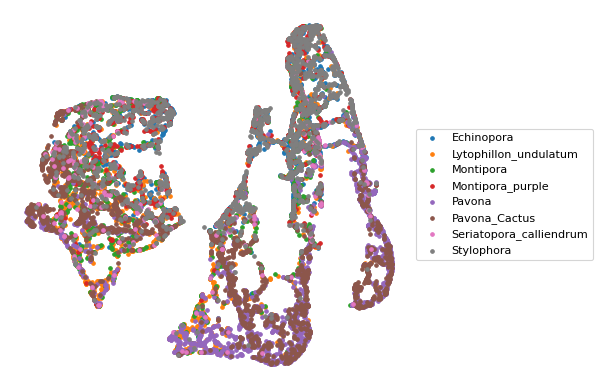

In [37]:
groups = emb.groupby('specie')
fig, ax = plt.subplots(figsize=(8,8),dpi=80)
ax.set_aspect('equal')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group.UMAP1, group.UMAP2, marker='o', label=name,s=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.axis('off')
#plt.savefig("UMAP_species.svg")

## Plot species distribution on UMAP

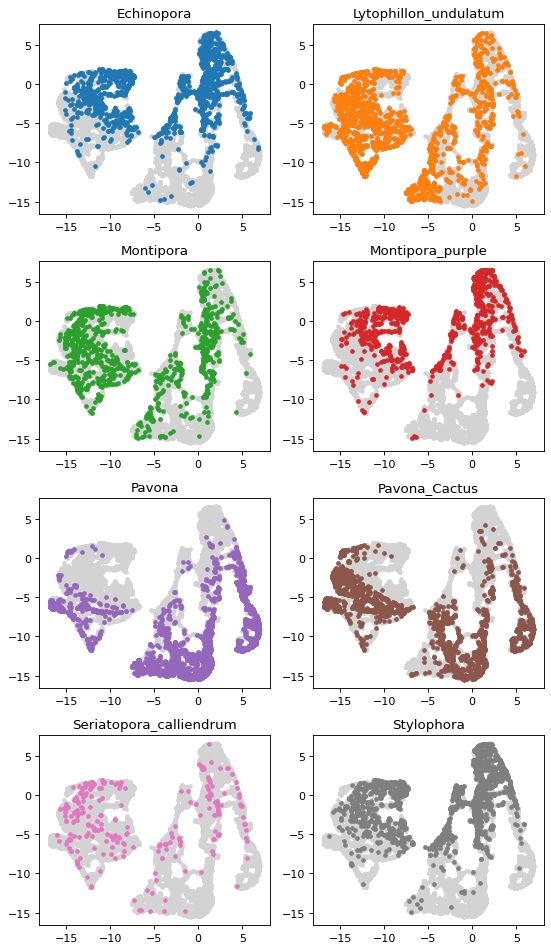

In [38]:
fig, ax = plt.subplots(figsize=(7,12),dpi=80)
k=1
for name, group in groups:
    plt.subplot(4,2,k)
    plt.scatter(emb.UMAP1, emb.UMAP2, marker='o', c="lightgrey",label=name,s=10)
    plt.scatter(group.UMAP1, group.UMAP2, marker='o',c="C"+str(k-1),s=10)
    plt.title(name)
    k=k+1
plt.tight_layout()

#plt.savefig("UMAP_species_separate.svg")

## Plot features on UMAP

In [33]:
def format_percentile(val,p=5):
    perc=np.percentile(val,[p,100-p])
    val[val<perc[0]]=perc[0]
    val[val>perc[1]]=perc[1]
    return(val)

/home/lfaure/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lfaure/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


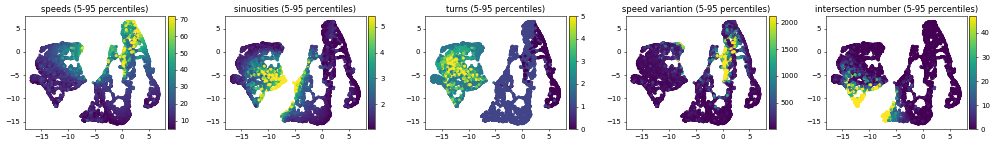

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(20,3),dpi=50)
ax = plt.subplot(1,5,1)
pl=ax.scatter(emb.UMAP1,emb.UMAP2,c=format_percentile(alldat.speedmean),cmap="viridis", marker='o',s=10)
plt.title("speeds (5-95 percentiles)")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(pl, cax=cax)

ax = plt.subplot(1,5,2)
pl=ax.scatter(emb.UMAP1,emb.UMAP2,c=format_percentile(alldat.sin),cmap="viridis", marker='o',s=10)
plt.title("sinuosities (5-95 percentiles)")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(pl, cax=cax)

ax=plt.subplot(1,5,3)
pl=ax.scatter(emb.UMAP1,emb.UMAP2,c=format_percentile(alldat.turns),cmap="viridis", marker='o',s=10)
plt.title("turns (5-95 percentiles)")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(pl, cax=cax)

ax=plt.subplot(1,5,4)
pl=ax.scatter(emb.UMAP1,emb.UMAP2,c=format_percentile(alldat.speedvar),cmap="viridis", marker='o',s=10)
plt.title("speed variantion (5-95 percentiles)")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(pl, cax=cax)


ax=plt.subplot(1,5,5)
pl=ax.scatter(emb.UMAP1,emb.UMAP2,c=format_percentile(alldat.inter),cmap="viridis", marker='o',s=10)
plt.title("intersection number (5-95 percentiles)")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(pl, cax=cax)

plt.tight_layout()
#plt.savefig("UMAP_features.svg")

# Gather all tracks for visualisation

In [10]:
all_ldata=[item for sublist in all_ldata for item in sublist]

In [ ]:
from emb_tools import rasterizelines
res=list(p_map(rasterizelines,all_ldata))
# mat=np.stack(res,axis=0)
# sparse_matrix = scipy.sparse.csc_matrix(mat)
# scipy.sparse.save_npz('mat.npz', sparse_matrix)

In [20]:
mat=np.stack(res,axis=0)
sparse_matrix = scipy.sparse.csc_matrix(mat)
scipy.sparse.save_npz('mat.npz', sparse_matrix)

In [36]:
sparse_matrix = scipy.sparse.load_npz('mat.npz')
mat=sparse_matrix.todense()
res=np.vsplit(mat,mat.shape[0])
for idx in idx_torem:
    del res[idx]

In [38]:
from emb_tools import show_embedding

show_embedding(emb,alldat,res)

/home/lfaure/miniconda3/lib/python3.7/site-packages/bokeh-2.0.0-py3.7.egg/bokeh/models/mappers.py:147: UserWarning: Palette length does not match number of factors. ['Seriatopora_calliendrum', 'Stylophora'] will be assigned to `nan_color` gray
  warnings.warn("Palette length does not match number of factors. %s will be assigned to `nan_color` %s" % (extra_factors, self.nan_color))
